In [2]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import math
import random
import gc
from python_speech_features import logfbank,delta


In [9]:
def eachFile(filepath):
    pathDir = os.listdir(filepath)
    for filename in pathDir:
        if os.path.splitext(filename)[1] != ".csv":
            pathDir.remove(filename)
    pathDir.sort(key = lambda x: int(x[:-4]))
    path = []
    for allDir in pathDir:
        child = os.path.join('%s%s'%(filepath,allDir))
        path.append(child)
    return path
def load_fbank_feature(train_path,train_floder,sample_rate):
    bug = 0
    fbank_feature = []
    label = []
    for each_floder in train_floder:
        file_set = eachFile(train_path+each_floder+"Sensor1/")
        entire_life = len(file_set)*5
        for each in file_set:
            each_data = pd.read_csv(each)["vibration_1"]
            print(each)
            if len(each_data)%sample_rate != 0:
                leng = len(each_data)//sample_rate 
                each_data = each_data[:leng*sample_rate] ### (60*sample_rate,)
            
            each_data = np.array(each_data)
#             each_data = denose_data(each_data,"db5",3)
            each_data = np.reshape(each_data,(-1,sample_rate))
            for each_sample in each_data:
#                 each_feature = []
                each_fbank_feature = logfbank(each_sample,sample_rate,winlen=0.04,winstep=0.02,
                                              nfft=1024,nfilt=40)
#                 each_d_feature = delta(each_fbank_feature,2)
#                 each_dd_feature = delta(each_d_feature,2)
#                 each_feature = np.column_stack((each_fbank_feature,each_d_feature,each_dd_feature))
#                 each_fbank_feature2 = logfbank(each_sample[:,1],sample_rate,winlen=0.04,winstep=0.02,
# nfft=1024,nfilt=40)
            ### (frames_numbers,feature_num == 40)
#                 each_feature.append(each_fbank_feature1)
#                 each_feature.append(each_fbank_feature2)
                fbank_feature.append(each_fbank_feature)
#                 assert bug == 1,"Debugging"

            index = int(each.split('/')[-1].split('.')[0])
            residual_life = entire_life - index*5
            each_label = np.array([residual_life]*len(each_data))### (leng,)
            each_label = np.reshape(each_label,[-1,1]) ### (leng,1)
            label.extend(each_label)

    fbank_feature = np.array(fbank_feature)
    label = np.array(label)
    print(fbank_feature.shape)
    print(label.shape)
    return fbank_feature,label

In [10]:
train_path = "../../01-TrainingData-additional/"
train_floder1 = ["01/"]
train_floder2 = ["02/"]
train_floder3 = ["03/"]
sample_rate = 25600

In [11]:
train_data1,train_label1 = load_fbank_feature(train_path,train_floder1,sample_rate)
train_data2,train_label2 = load_fbank_feature(train_path,train_floder2,sample_rate)
train_data3,train_label3 = load_fbank_feature(train_path,train_floder3,sample_rate)
train_data=np.append(train_data1,train_data2,axis=0)
train_data=np.append(train_data,train_data3,axis=0)
train_label=np.append(train_label1,train_label2,axis=0)
train_label=np.append(train_label,train_label3,axis=0)
valid_data=train_data1
valid_label=train_label1
valid_data=train_data1
valid_label=train_label1
print(train_data.shape,train_label.shape)
print(valid_data.shape,valid_label.shape)
gc.collect()

../../01-TrainingData-additional/01/Sensor1/1.csv
../../01-TrainingData-additional/01/Sensor1/2.csv
../../01-TrainingData-additional/01/Sensor1/3.csv
../../01-TrainingData-additional/01/Sensor1/4.csv
../../01-TrainingData-additional/01/Sensor1/5.csv
../../01-TrainingData-additional/01/Sensor1/6.csv
../../01-TrainingData-additional/01/Sensor1/7.csv
../../01-TrainingData-additional/01/Sensor1/8.csv
../../01-TrainingData-additional/01/Sensor1/9.csv
../../01-TrainingData-additional/01/Sensor1/10.csv
../../01-TrainingData-additional/01/Sensor1/11.csv
../../01-TrainingData-additional/01/Sensor1/12.csv
../../01-TrainingData-additional/01/Sensor1/13.csv
../../01-TrainingData-additional/01/Sensor1/14.csv
../../01-TrainingData-additional/01/Sensor1/15.csv
../../01-TrainingData-additional/01/Sensor1/16.csv
../../01-TrainingData-additional/01/Sensor1/17.csv
../../01-TrainingData-additional/01/Sensor1/18.csv
../../01-TrainingData-additional/01/Sensor1/19.csv
../../01-TrainingData-additional/01/Sens

337

In [12]:
miu = np.mean(train_data)
sigma = np.std(train_data)
valid_data = (valid_data-miu)/sigma
train_data  = (train_data - miu)/sigma
train_data = np.reshape(train_data,(-1,49,40,1))
valid_data = np.reshape(valid_data,(-1,49,40,1))
print(train_data.shape,train_label.shape)
print(valid_data.shape,valid_label.shape)
gc.collect()

(7667, 49, 40, 1) (7667, 1)
(2789, 49, 40, 1) (2789, 1)


0

In [13]:
from keras import models as M
from keras import layers as L
from keras import optimizers
from keras import metrics
import functools
from keras.callbacks import ModelCheckpoint

from keras.callbacks import Callback
graph = None
model = None

Using TensorFlow backend.


In [14]:
def evaluation_metric(y_true, y_pred):
    y_true, y_pred = tf.reshape(y_true, [-1]), tf.reshape(y_pred, [-1])
    er = y_true - y_pred
    mask_n, mask_p = (er<=0), (er>0)
    er_n, er_p = tf.boolean_mask(er, mask_n), tf.boolean_mask(er, mask_p)
    score_n = tf.exp(-tf.log(0.5)*er_n/5)
    score_p = tf.exp(tf.log(0.5)*er_p/20)
    score = tf.concat([score_n, score_p], 0)
    score = tf.reduce_mean(score)*100
    return score
def cust_loss(y_real,y_predicted):
    y_diff = y_real - y_predicted
    loss = tf.where(tf.greater(y_diff, 0),
                    -tf.exp(tf.log(0.5) * (y_diff / 20)) +1,
                    -tf.exp(-tf.log(0.5) * (y_diff / 5)) +1)
    return loss*tf.reduce_max(abs(y_diff))

In [15]:
import matplotlib.pyplot as plt
def plt_plot(y_real,y_predicted):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(range(len(y_real)),y_real, color='g')
    ax.plot(range(len(y_predicted)),y_predicted,color='r')
    plt.show()
def Error_compute(y_real,y_predicted):
    y_diff=y_real-y_predicted
    diff_positive=y_diff[y_diff>0]
    diff_negitive_0=y_diff[y_diff<=0]
    if diff_negitive_0.shape[0] >0:
        sum_negitive_error=sum(np.exp(-np.log(0.5)*(diff_negitive_0/5)))
    else:
        sum_negitive_error=0
    if diff_positive.shape[0] >0:
        sum_positive_error=sum(np.exp(np.log(0.5)*(diff_positive/20)))
    else:
        sum_positive_error=0
    return (sum_negitive_error+sum_positive_error)/len(y_real)

In [16]:
def model_CNN(input_shape):
    x_input = L.Input(shape=input_shape)
    print(x_input.shape)
#     x = L.BatchNormalization(axis=3)(x_input)
    x = L.Conv2D(16,(3,3),activation='relu')(x_input)
    x = L.MaxPool2D((3,3),strides=(2,2))(x)
    x = L.Conv2D(32,(3,3),activation='relu')(x)
    x = L.Conv2D(32,(3,3),activation='relu')(x)
    x = L.MaxPool2D((3,3),strides=(2,2))(x)
    x = L.Conv2D(64,(3,3),activation='relu')(x)
#     x = L.MaxPool2D((3,3),strides=(2,2))(x)
    x = L.Flatten()(x)
    x = L.Dense(512,activation="relu")(x)
    x = L.Dense(1024,activation="relu")(x)
#     x = L.Dropout(0.5)(x)

    y = L.Dense(1)(x)
    
    model = M.Model(inputs=x_input, outputs=y, name="VGG_CNN")
    return model

In [17]:
checkpoint = ModelCheckpoint(filepath="./2conv+2fc+denose.h5",monitor='val_evaluation_metric',verbose=1,save_best_only='True',
                             mode='max',period=1)
# tensorboard = TensorBoard(log_dir='log(./)')
callback_lists = [checkpoint]  #因为callback是list型,必须转化为list
graph = tf.get_default_graph()
model = model_CNN((49,40,1))
model.summary()

(?, 49, 40, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 49, 40, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 38, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 18, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 16, 32)        4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 19, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 6, 32)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 4, 64)          18496 

In [18]:
Adam = optimizers.Adam(lr=5e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer=Adam, loss=cust_loss, metrics=[evaluation_metric])
history = model.fit(train_data, train_label, batch_size=16, epochs=100,verbose=1,validation_data=(valid_data, valid_label),
          callbacks=callback_lists)

Train on 7667 samples, validate on 2789 samples
Epoch 1/100
7667/7667 [==============================] - 19s 3ms/step - loss: 101.7254 - evaluation_metric: 18.9511 - val_loss: 59.8882 - val_evaluation_metric: 23.1919

Epoch 00001: val_evaluation_metric improved from -inf to 23.19189, saving model to ./2conv+2fc+denose.h5
Epoch 2/100
7667/7667 [==============================] - 19s 2ms/step - loss: 81.3154 - evaluation_metric: 22.4321 - val_loss: 80.1152 - val_evaluation_metric: 15.1480

Epoch 00002: val_evaluation_metric did not improve from 23.19189
Epoch 3/100
7667/7667 [==============================] - 19s 2ms/step - loss: 71.8872 - evaluation_metric: 25.8598 - val_loss: 39.7610 - val_evaluation_metric: 36.8404

Epoch 00003: val_evaluation_metric improved from 23.19189 to 36.84038, saving model to ./2conv+2fc+denose.h5
Epoch 4/100
7667/7667 [==============================] - 19s 2ms/step - loss: 63.9910 - evaluation_metric: 29.2228 - val_loss: 49.1683 - val_evaluation_metric: 32.20

In [ ]:
tf.__version__

In [40]:
gc.collect()
test_index=5
test_path = "../../02-TestingData-keD1/"
test_floder1 = ["00/","01/","02/","03/","04/","05/"]

test_data,test_label = load_fbank_feature(test_path,[test_floder1[test_index]],sample_rate)
miu = np.mean(test_data)
sigma = np.std(test_data)
test_data  = (test_data - miu)/sigma
test_data = np.reshape(test_data,(-1,49,40,1))
print(test_data.shape,test_data.shape)
gc.collect()

../../02-TestingData-keD1/05/Sensor1/1.csv
../../02-TestingData-keD1/05/Sensor1/2.csv
../../02-TestingData-keD1/05/Sensor1/3.csv
../../02-TestingData-keD1/05/Sensor1/4.csv
../../02-TestingData-keD1/05/Sensor1/5.csv
../../02-TestingData-keD1/05/Sensor1/6.csv
../../02-TestingData-keD1/05/Sensor1/7.csv
../../02-TestingData-keD1/05/Sensor1/8.csv
../../02-TestingData-keD1/05/Sensor1/9.csv
../../02-TestingData-keD1/05/Sensor1/10.csv
(600, 49, 40)
(600, 1)
(600, 49, 40, 1) (600, 49, 40, 1)


0

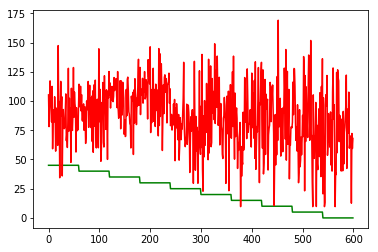

(600, 1)
0.00046279224711357186


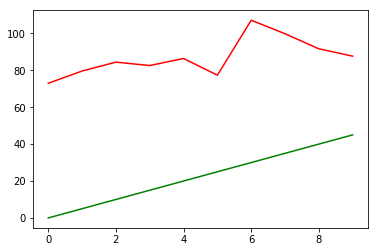

In [41]:
# from keras.models import load_model
# model = load_model('2conv+2fc+denose.h5',{"evaluation_metric":evaluation_metric})
y_predicted=model.predict(test_data)
plt_plot(test_label,y_predicted)
print(y_predicted.shape)
df_result=pd.DataFrame(np.concatenate((test_label,y_predicted),axis=1),columns=["real","predicted"])
df_predict=df_result["predicted"].groupby(df_result['real']).mean()
err=Error_compute(df_predict.index,df_predict)
# df_predict=df_predict.sort_index(ascending=False)
print(err)
plt_plot(df_predict.index,df_predict)
df_result.to_csv("%d_cnn_test_predicted.csv"%test_index,index=False)

In [ ]:
y_predicted=model.predict(valid_data)
print(y_predicted.shape)
# 
df_result=pd.DataFrame(np.concatenate((valid_label,y_predicted),axis=1),columns=["real","predicted"])
plt_plot(valid_label,y_predicted)

In [ ]:
df_predict=df_result["predicted"].groupby(df_result['real']).mean()
# df_predict=df_predict
err=Error_compute(df_predict.index,df_predict)
df_predict=df_predict.sort_index(ascending=False)
print(err)
plt_plot(df_predict.index,df_predict)

In [ ]:
df_predicted=pd.DataFrame(y_predicted,columns=['predicted'])
# df_predicted.to_csv("3_cnn_predicted.csv",index=False)
df_predicted.shape

In [ ]:
df_temp1=pd.read_csv("1_cnn_predicted.csv")
print(df_temp1.shape)
df_temp2=pd.read_csv("2_cnn_predicted.csv")
print(df_temp2.shape)
df_temp3=pd.read_csv("3_cnn_predicted.csv")
print(df_temp3.shape)